In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Load behavioral data

In [3]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

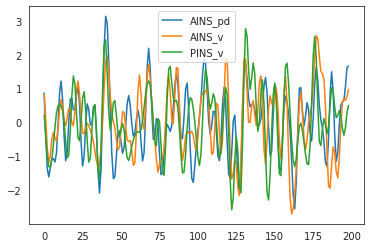

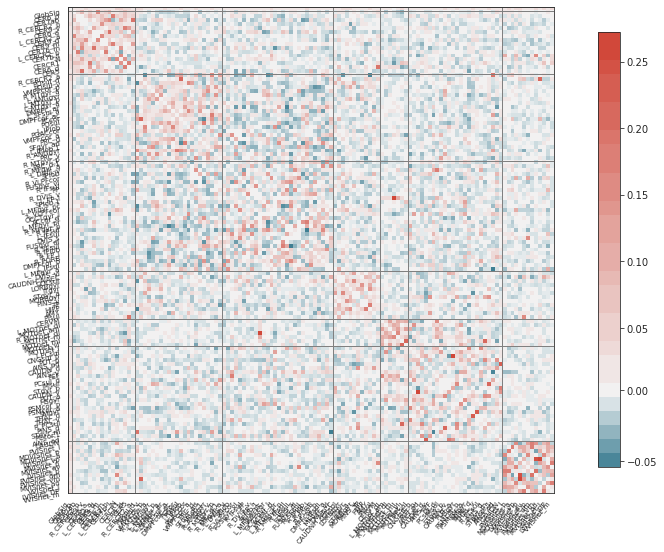

In [4]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [5]:
X.shape

(91, 123, 123)

# Load participant-level connectivity data

In [61]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
mc_model = mc_model[mc_model['abs_multi-center']>0.05]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    conns_mc_model[:, idx] = X[:, i_a, i_b]
    #if mc_model.iloc[idx,:]['multi-center'] < 0:
    #    conns_mc_model[:, idx] *= -1
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model


connectivity,GlobSig - VMPFcor_p,CER6_p - PSMcor_p,R_CERCR2_p - STgyr_a,CER7b_m - PCcor.1,CER6_d - MOTnet_m,R_CERCR2_a - MOTnet_l,POsul_v - R_PORB,R_MTgyr_a - SFgyr_ad,L_ANGgyr - R_IPlob,L_ANGgyr - LVISnet_vp,...,R_MFgyr_a - PUT_p,R_DVIS_v - AMY,L_VLPFcor - SMgyr,FUSgyr_dl - AMY,R_IPlob - STgyr_p,L_MFgyr_a - LORBgyr,CAUDNH_NACC - MOTnet_vl,MOTnet_m - LVISnet_p,AINS_v - MVISnet_ad,THAL_v - PINS_d
0,0.021891,0.127759,-0.064799,-0.042026,-0.100725,-0.008141,0.012688,0.010114,-0.045587,0.067405,...,-0.039159,-0.096887,-0.009629,0.023218,-0.065551,-0.012065,0.054709,-0.046985,0.112617,-0.006091
1,0.015723,0.094542,-0.074666,0.091628,0.012459,-0.013263,-0.108726,0.095612,-0.042899,-0.086473,...,-0.060029,-0.050648,-0.012129,0.039165,-0.005558,0.067681,0.077508,0.023110,0.137049,0.032730
2,0.013114,-0.090155,0.030321,-0.196758,-0.059550,0.039759,-0.003997,0.003227,0.016751,-0.055042,...,0.056125,-0.074152,-0.035919,0.107869,0.044654,-0.003242,0.011217,-0.017286,0.104354,-0.111940
3,0.020028,-0.031791,0.042861,0.030311,0.036209,0.001495,0.017882,-0.025220,0.028221,-0.001196,...,0.082366,0.013100,-0.037373,0.099864,-0.003451,0.033829,-0.082446,0.066444,-0.022866,0.060156
4,0.027947,-0.003799,-0.029537,0.017608,-0.045649,0.041137,-0.058711,0.063461,0.047826,-0.010763,...,-0.043751,0.019699,0.038561,0.089634,-0.030480,-0.038245,-0.159668,0.021621,-0.010212,0.064941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.031210,0.011089,-0.017681,-0.048726,-0.004617,0.082522,-0.023276,0.055518,-0.090986,-0.056663,...,0.068212,0.045120,0.022682,0.071769,0.010992,0.045305,0.025894,0.020761,0.040750,0.095300
87,0.021306,0.037766,-0.082971,-0.028058,0.055295,0.110673,0.028218,0.038516,-0.038433,-0.014910,...,-0.033569,-0.006714,0.035804,0.008186,-0.047451,0.077870,-0.138718,-0.047688,0.042326,-0.052292
88,0.014579,-0.108385,0.046721,-0.066575,0.054301,-0.038752,-0.003549,0.014955,0.011992,0.025923,...,0.039910,0.010972,-0.070938,0.016668,0.014420,-0.199809,-0.006506,-0.020835,-0.049692,-0.025747
89,0.019275,-0.146022,0.005831,0.146273,0.030448,-0.090696,0.001555,0.050563,-0.028415,0.052127,...,0.129942,-0.021536,-0.004820,0.074293,-0.020894,0.014597,-0.046275,-0.016585,-0.005255,-0.094788


In [81]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]

df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1
df2['study'] = df.study.astype('category').cat.codes

#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'pcs_catastrophizing', 'pcs_rumination']]
#vars = df2[['CPT', 'nHPT', 'nMPT', 'npsq', 'nanx_state', 'nanx_trait']]
vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k']]

vars.corrwith(df.mean_QST_pain_sensitivity)

CPT                    0.714782
nHPT                   0.769679
nMPT                   0.634185
nt50                   0.534950
npsq                   0.190144
nanx_state             0.202458
nanx_trait             0.204718
pcs_catastrophizing    0.134912
pcs_rumination         0.215321
PSQI                   0.296726
PSQ20                  0.308412
ads_k                  0.081807
dtype: float64

In [82]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

connectivity,GlobSig - VMPFcor_p,CER6_p - PSMcor_p,R_CERCR2_p - STgyr_a,CER7b_m - PCcor.1,CER6_d - MOTnet_m,R_CERCR2_a - MOTnet_l,POsul_v - R_PORB,R_MTgyr_a - SFgyr_ad,L_ANGgyr - R_IPlob,L_ANGgyr - LVISnet_vp,...,R_MFgyr_a - PUT_p,R_DVIS_v - AMY,L_VLPFcor - SMgyr,FUSgyr_dl - AMY,R_IPlob - STgyr_p,L_MFgyr_a - LORBgyr,CAUDNH_NACC - MOTnet_vl,MOTnet_m - LVISnet_p,AINS_v - MVISnet_ad,THAL_v - PINS_d
CPT,0.218888,-0.231473,-0.136003,0.269774,-0.193640,0.243671,0.267249,-0.132463,0.014934,-0.305363,...,-0.362295,-0.005978,-0.335387,-0.147163,-0.183506,0.305101,0.069552,0.174136,-0.219074,0.138239
nHPT,0.161564,-0.254461,-0.232522,0.167964,-0.172492,0.365708,0.237226,-0.253320,-0.154611,-0.384027,...,-0.358422,0.320088,-0.158544,-0.271482,-0.221293,0.153008,0.137473,0.298346,-0.228620,0.187179
nMPT,0.301945,-0.201422,-0.118144,0.219451,-0.327756,0.254165,0.179729,-0.246152,-0.287635,0.005072,...,-0.140173,0.114731,-0.216008,-0.373025,-0.220520,0.169292,0.233771,0.439023,-0.171467,0.248983
nt50,0.009989,-0.319194,0.015976,0.255984,-0.047768,0.285224,0.309845,-0.259524,0.008543,-0.366696,...,0.128484,-0.059432,0.114322,-0.228096,-0.167443,0.233145,0.018380,0.408920,-0.324741,0.286114
npsq,0.361906,-0.009865,0.105488,-0.059947,-0.274854,0.265258,0.119034,-0.068143,0.002239,-0.099046,...,-0.027425,-0.233618,-0.019735,-0.112660,-0.025163,0.035462,-0.180290,0.282711,-0.083695,-0.010707
nanx_state,0.394896,-0.026690,0.144962,-0.149586,-0.263870,0.190322,0.137033,-0.028228,0.043395,-0.080784,...,-0.032159,-0.170444,0.020851,-0.159439,-0.008040,0.073469,-0.158115,0.260548,-0.179421,-0.035873
nanx_trait,0.385377,-0.042216,0.153239,-0.143312,-0.263757,0.186312,0.132516,-0.051171,0.002195,-0.075248,...,-0.023316,-0.169189,0.047630,-0.193610,0.015895,0.053506,-0.146116,0.278432,-0.172157,-0.021476
pcs_catastrophizing,0.005730,-0.111155,0.024004,0.099360,0.050974,-0.178508,-0.037305,-0.078607,-0.028674,-0.008057,...,0.056496,0.045765,-0.127410,-0.022773,-0.303288,0.001743,-0.098274,0.032641,0.000470,-0.000595
pcs_rumination,0.159344,-0.025577,-0.262166,-0.201499,-0.202025,-0.147196,0.158920,0.093884,-0.070977,-0.109805,...,-0.154895,0.085755,0.066998,0.135578,-0.332272,-0.193518,-0.050864,-0.075319,-0.249635,0.025208
PSQI,-0.080914,-0.190889,-0.027921,-0.091958,-0.209217,0.130322,0.065993,-0.076015,0.164603,-0.044754,...,-0.274721,0.009259,-0.250088,-0.214990,0.132302,0.157766,-0.046018,0.352548,-0.025996,0.015165


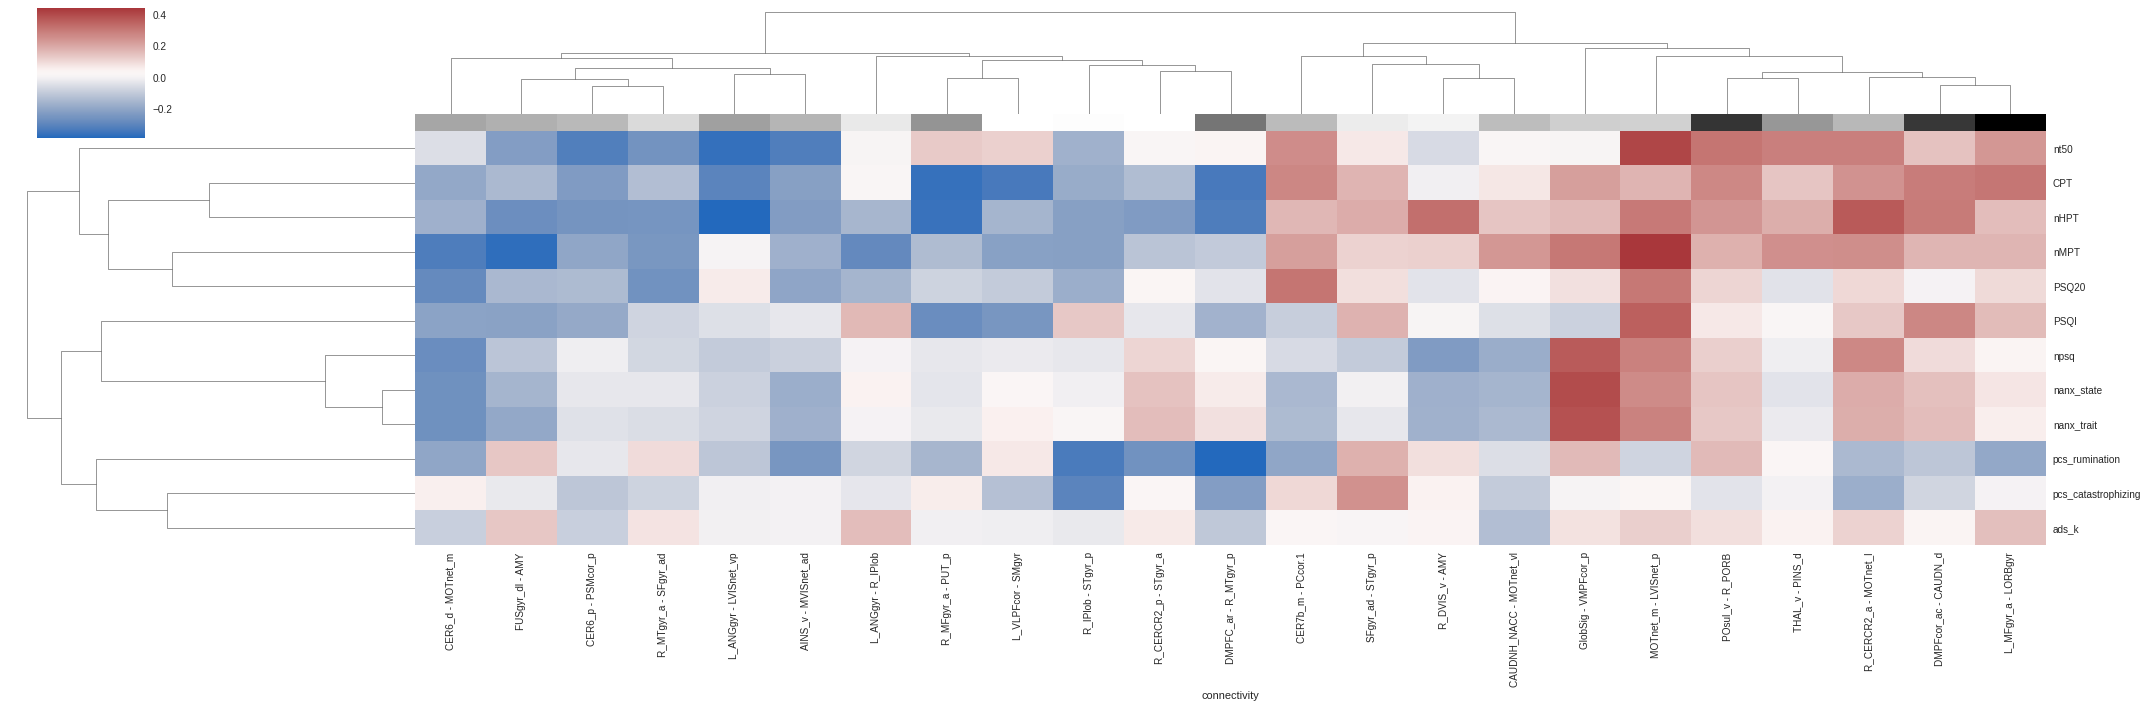

In [83]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [84]:
fig.savefig('../res/multi-center/cluster_map.pdf')

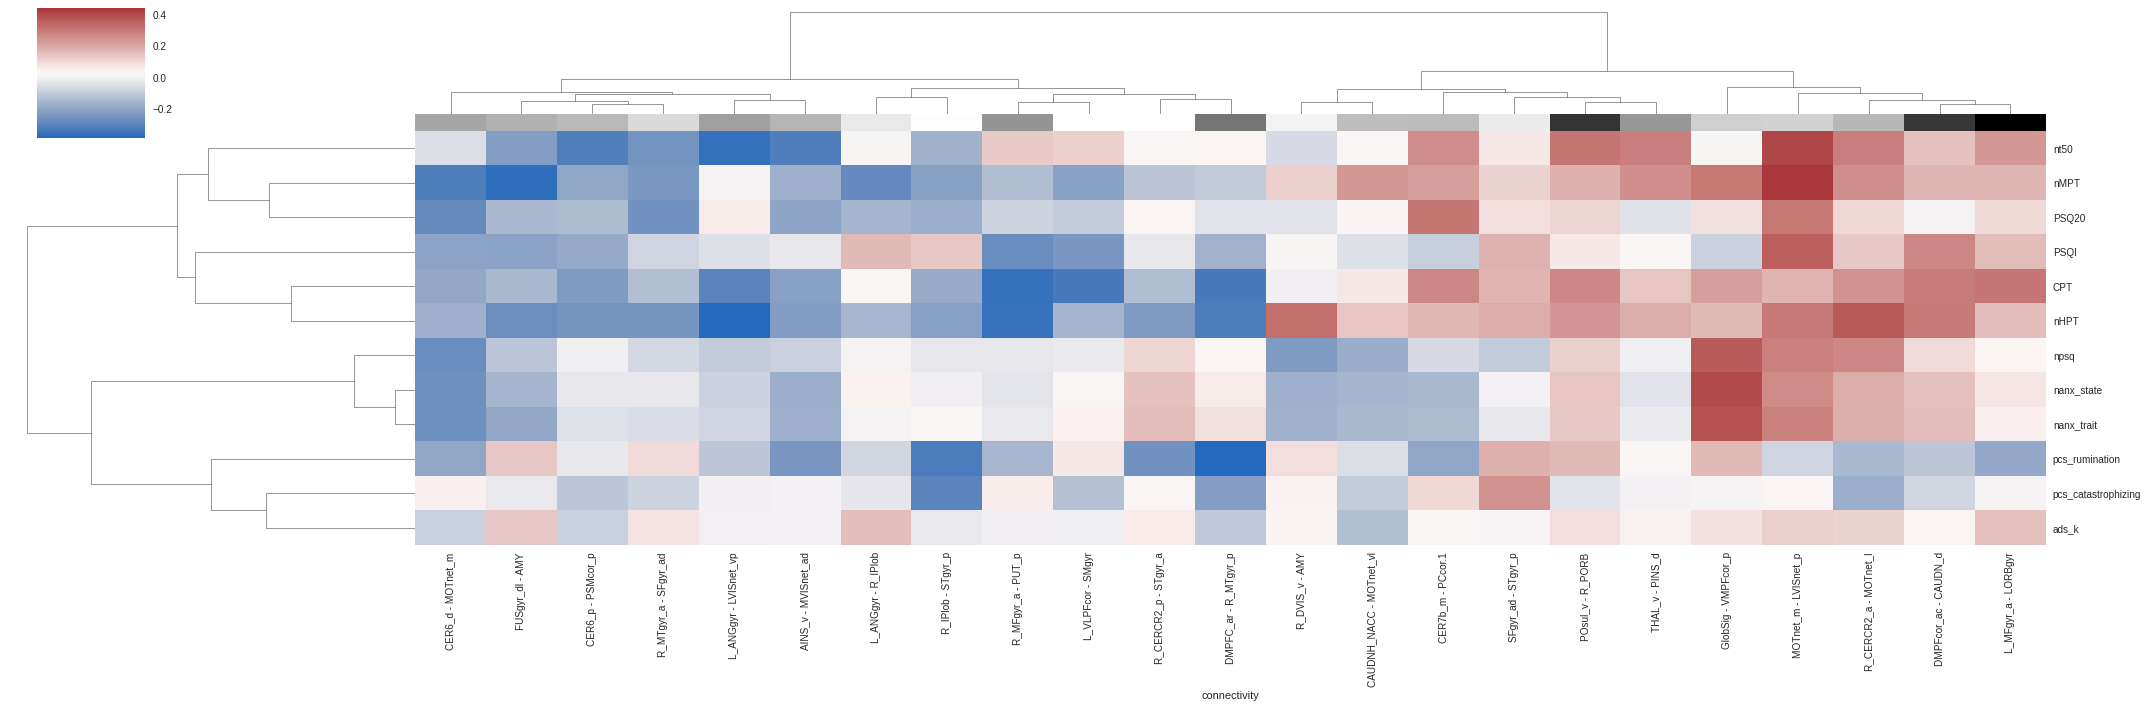

In [85]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='ward', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [86]:
fig.savefig('../res/multi-center/cluster_map2.pdf')

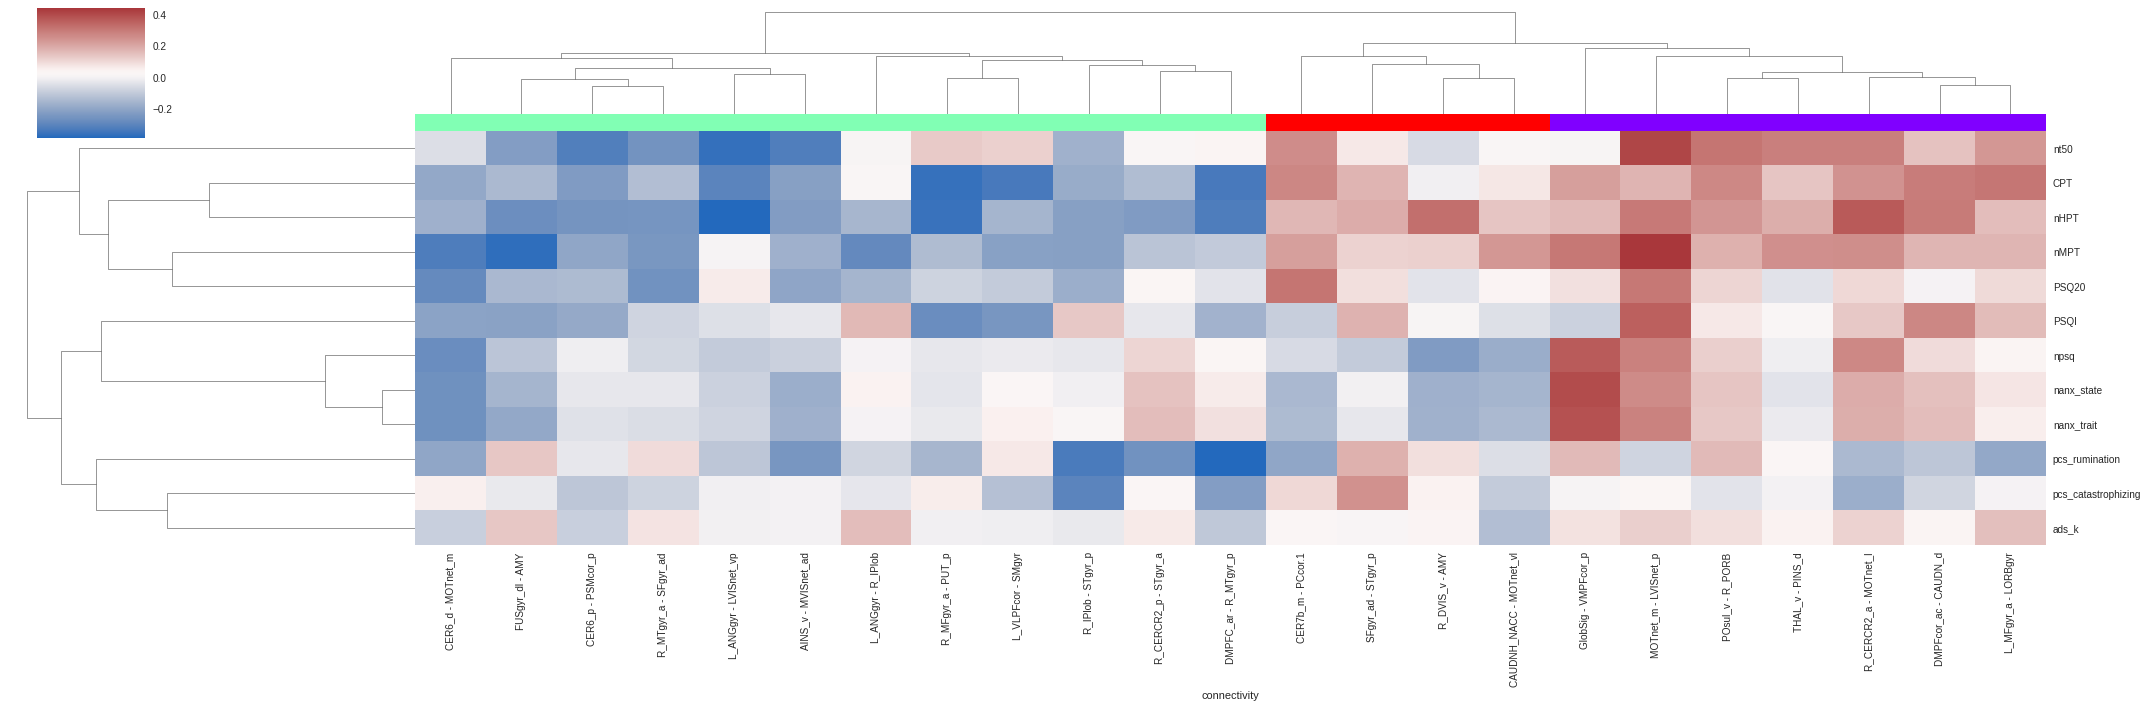

In [94]:
from sklearn.cluster import AgglomerativeClustering, KMeans
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', metric='euclidean', cmap="vlag", figsize=(30,10), col_colors=cm.rainbow(norm(AgglomerativeClustering(n_clusters=3, linkage="average", affinity='euclidean').fit(corrmtx.dropna().T).labels_)))

In [88]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

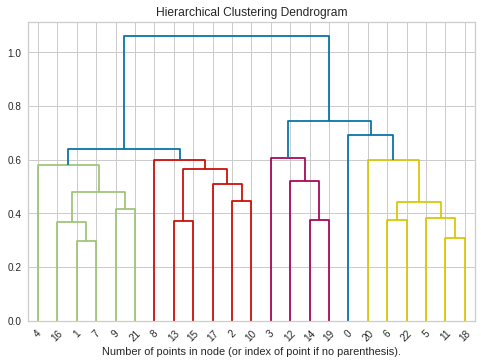

In [89]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(corrmtx.T)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, color_threshold=0.63)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

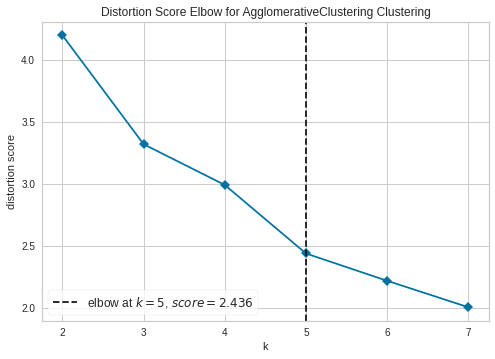

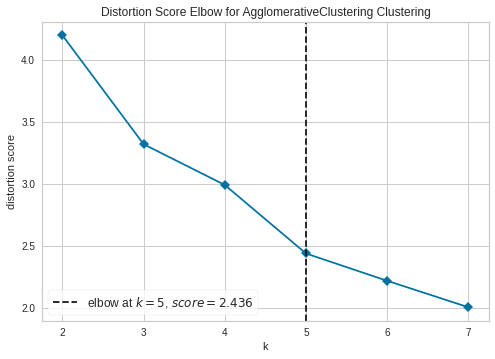

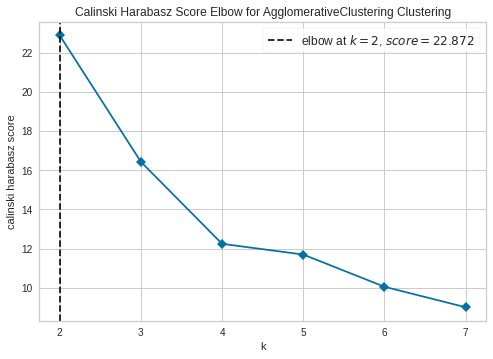

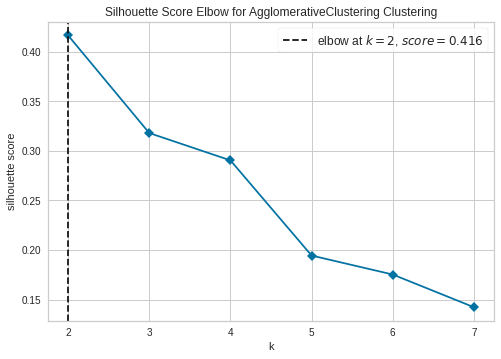

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering(linkage='average', affinity='euclidean')
# k is range of number of clusters.
kmax = 8 #corrmtx.shape[1]

visualizer = KElbowVisualizer(model, k=(2,8), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='calinski_harabasz') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='silhouette') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()

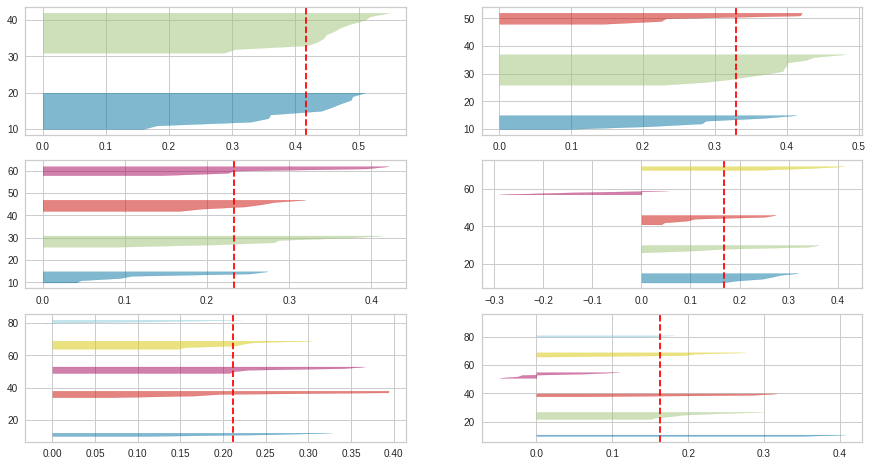

In [91]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer


fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=None)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(corrmtx.T)

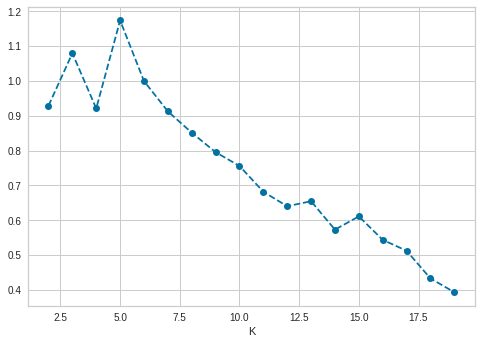

In [92]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = AgglomerativeClustering(n_clusters=center, linkage='average', affinity='euclidean')# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)

    # Calculate Davies Bouldin scorescore = davies_bouldin_score(cluster_df, model)
    score = davies_bouldin_score(data, model)

    return score

scores = []

centers = list(range(2,20))
for center in centers:
    scores.append(get_kmeans_score(corrmtx.T, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');